## Build and Train

In [2]:
import tensorflow as tf
from boltzmann.data.mnist import load_mnist
from boltzmann.restricted.base import train, LogInternalInformation
from boltzmann.restricted.bernoulli.common import GlorotInitializer
from boltzmann.restricted.bernoulli.dense import (
    DenseBernoulliRBM, initialize_fantasy_latent, get_reconstruction_error)

IMAGE_SIZE = (16, 16)
SEED = 42

tf.random.set_seed(SEED)

In [3]:
(X, y), _ = load_mnist(image_size=IMAGE_SIZE, binarize=True,
                       minval=0, maxval=1)

ambient_size = IMAGE_SIZE[0] * IMAGE_SIZE[1]
latent_size = 64
sparsity = 0
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(20).batch(batch_size)
rbm = DenseBernoulliRBM(ambient_size, latent_size, GlorotInitializer(X),
                        sparsity=sparsity)
fantasy_latent = initialize_fantasy_latent(latent_size, batch_size)
optimizer = tf.optimizers.Adam()
callbacks = [LogInternalInformation(rbm, log_step=10, verbose=True)]
fantasy_latent = train(rbm, optimizer, dataset, fantasy_latent,
                       callbacks=callbacks)

nt: 0.34119 (0.47411) - kernel: -0.09784 (0.42590) - ambient bias: -5.99103 (6.26713) - latent bias: 0.22974 (0.57352)
step: 7970 - real latent: 0.35352 (0.47806) - kernel: -0.09830 (0.42604) - ambient bias: -5.99174 (6.26685) - latent bias: 0.22998 (0.57494)
step: 7980 - real latent: 0.35010 (0.47700) - kernel: -0.09856 (0.42626) - ambient bias: -5.99241 (6.26656) - latent bias: 0.23111 (0.57683)
step: 7990 - real latent: 0.34668 (0.47591) - kernel: -0.09853 (0.42653) - ambient bias: -5.99241 (6.26662) - latent bias: 0.23185 (0.57754)
step: 8000 - real latent: 0.34094 (0.47403) - kernel: -0.09837 (0.42688) - ambient bias: -5.99176 (6.26714) - latent bias: 0.23188 (0.57737)
step: 8010 - real latent: 0.35388 (0.47817) - kernel: -0.09822 (0.42731) - ambient bias: -5.99062 (6.26785) - latent bias: 0.23095 (0.57658)
step: 8020 - real latent: 0.34314 (0.47476) - kernel: -0.09816 (0.42772) - ambient bias: -5.98983 (6.26834) - latent bias: 0.23018 (0.57709)
step: 8030 - real latent: 0.34363 (

In [5]:
get_reconstruction_error(rbm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.052948438>

## Visualize the Latent

In [6]:
from sklearn.manifold import TSNE
from boltzmann.restricted.base import relax, RestrictedBoltzmannMachine

def get_relaxed_latent_projection(
        rbm: RestrictedBoltzmannMachine,
        ambient: tf.Tensor,
        max_iter: int = 10,
        tol: float = 1e-8):
    relaxed_ambient, _ = relax(rbm, ambient, max_iter, tol)
    relaxed_latent = rbm.get_latent_given_ambient(relaxed_ambient).prob_argmax
    projection = TSNE().fit_transform(relaxed_latent)
    return projection

In [7]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(rbm, np.array(X_in_labels))

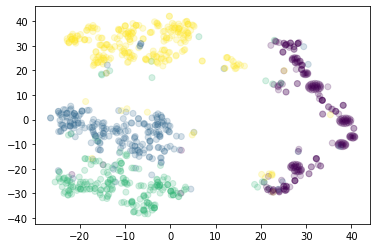

In [8]:
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

## Try Pruning

16384
tf.Tensor(0.05117969, shape=(), dtype=float32)


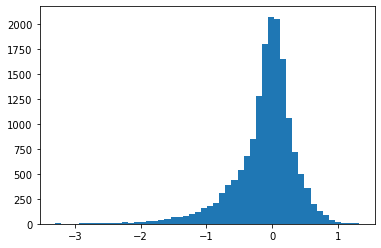

In [10]:
original_kernel = rbm.kernel.numpy()
plt.hist(original_kernel.reshape([-1]), bins=50)
plt.plot()

print(np.sum(np.where(np.abs(original_kernel) < 1e-8, 0, 1)))
print(get_reconstruction_error(rbm, X[:1000]))

8370
tf.Tensor(0.054515626, shape=(), dtype=float32)


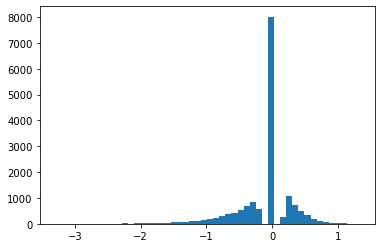

In [11]:
pruned_kernel = np.where(np.abs(original_kernel) < 0.2, 0., original_kernel)
plt.hist(pruned_kernel.reshape([-1]), bins=50)
plt.plot()

rbm._kernel.assign(pruned_kernel)
print(np.sum(np.where(np.abs(pruned_kernel) < 1e-8, 0, 1)))
print(get_reconstruction_error(rbm, X[:1000]))
_ = rbm._kernel.assign(original_kernel)